# Single Population Module

Create the functions to generate magnetic stellar population models

In [3]:
#imports
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
%matplotlib inline
import random
plt.rcParams.update({"font.size" : 14})
plt.rcParams.update({"axes.labelsize" : 14})

## Function definitions

In [4]:
#read MESA models
def read_track(file):
    '''
    Function that reads the MESA model files with all of its parameters
    
    Data file must be of type .data
    
    :par file: the file path containing the data to be read
    :rtype: Returns ndarray with the parameters
    '''
    
    data = np.genfromtxt( file, skip_header=5, names=True)
    return (data)

def read_track_small(file):
    '''
    Function that reads the MESA model with the columns of Star age, log(Teff), log(L), log(R), center_h1, Bp
    
    Data file must be of type .data
    
    :param file: the file path containing the data to be read
    :rtype: Returns ndarray with the parameters
    '''
    
    col  = [1,6,11,12,54,75]
    data = np.genfromtxt( file, skip_header=5, usecols=col, names=True)
    return (data)

#generate initial magnetic field functions

def get_B_uni(N, model_B_array = np.array([0, 1, 5, 10, 20]), Bmax=30.0):
    '''
    Function that generates a uniform disribution of initial magnetic field functions
    
    :param N: Number of stars in the cluster
    :param model_B_array: The model_B_array represent the lower edge of the magnetic field bins in kG. 
    :param Bmax: Bmax is the higher edge of the last bin
    '''
    
    B_bins = np.append(model_B_array, Bmax-0.01)
    B_dist = np.random.random_sample(int(N))*Bmax
    B_binned, edges = np.histogram(B_dist, bins=B_bins)
    
    return(B_binned)

def get_B_pow(N, model_B_array = np.array([0, 1, 5, 10, 20]), Bmin = 0.01, Bmax = 30.0, alphaB = 0.8 ):
    '''
    Function that generates a power law disribution of initial magnetic field functions
    
    :param N: Number of stars in the cluster
    :param model_B_array: The model_B_array represent the lower edge of the magnetic field bins in kG. 
    :param Bmin: Bmax is the lower edge of the last bin
    :param Bmax: Bmax is the higher edge of the last bin
    :param alpha: Value for the powerlaw index
    '''
    
    C = np.random.random(int(N))
    B_pow_rand = ( (Bmax**(1-alphaB)-Bmin**(1-alphaB))*C + Bmin**(1-alphaB) )**(1/(1-alphaB))

    B_bins = np.append(model_B_array, Bmax-0.01)
    B_binned, edges = np.histogram(B_pow_rand, bins=B_bins)
    
    return(B_binned)

In [45]:
class SingleStellarP:
    
    def __init__(self, M_1, M_2, alpha, epsilon_0):
        # This is for the masses for which we have models for
        self.M_width = M_2 - M_1
        self.N= np.round((epsilon_0/(1-alpha))*(M_2**(1-alpha)-M_1**(1-alpha)))

        #number of stars
        self.masstar = self.N[-1]
        self.totstar = np.sum(self.N)
    
    def populhist(self):
        fig, ax = plt.subplots(1,1, figsize=(15/2,6))
        plt.rcParams.update({'font.size': 22})
        #ax.scatter(M_1, N)
        ax.set_xlabel('Initial mass ($M_\odot$)')
        ax.set_ylabel('Number of Stars')

        ax.bar(M_1, self.N, width= self.M_width, align='edge', color='orchid', edgecolor = 'k')
        print(['{}'.format(x) for x in self.N])

        for i in range(0, M_1.size):
            ax.text(M_1[i]+self.M_width[i]/2, self.N[i], '{:0.0f}'.format(self.N[i]), ha='center' )

        ax.set_ylim(0,40)

    def initialbfunc(self, model_B_array):
        fig, ax = plt.subplots(1,3, figsize=(15,6))
        plt.rcParams.update({'font.size': 22})
        for item in ax:
            item.set_xlabel('Field strength (kG)')
            item.set_ylabel('Number of Stars')

        ax[0].set_title('Perfectly uniform')
        ax[1].set_title('Uniform')
        ax[2].set_title('Powerlaw')

        for item in ax:
            item.set_ylim(0,40)
            
        B_bins = np.append(model_B_array, 29.99)
        B_uniform = np.linspace(0, 29.99, 100)
        B_binned, edges = np.histogram(B_uniform, bins=B_bins)
        ax[0].bar(model_B_array, B_binned, width=B_bins[1:]-B_bins[0:-1], bottom=0, align='edge', color='pink', edgecolor = 'k')
        #print(np.sum(B_binned))

        mass_color = ['darkblue', 'blue', 'lightblue', 'lavender', 'lavenderblush']
        B_binned_total = np.zeros(model_B_array.size)
        for item, color in zip(self.N, mass_color):
            #print(item)

            B_binned = get_B_uni(item)
            #print(B_binned)
            ax[1].bar(model_B_array, B_binned, width=B_bins[1:]-B_bins[0:-1], 
                      bottom=B_binned_total, align='edge', color=color, edgecolor = 'k')
            B_binned_total = B_binned_total + B_binned

        B_binned_total = np.zeros(model_B_array.size)
        for item, color in zip(self.N, mass_color):
            #print(item)

            B_binned = get_B_pow(item)
            #print(B_binned)
            ax[2].bar(model_B_array, B_binned, width=B_bins[1:]-B_bins[0:-1], 
                      bottom=B_binned_total, align='edge', color=color, edgecolor = 'k')
            B_binned_total = B_binned_total + B_binned

        plt.tight_layout()

    def singleclustersim(self, path, model_B_array, B_limit = 500.0):
        fig, ax = plt.subplots(1,1)
        
        self.age=np.linspace(0.5,15, 50)*1e6 

        self.detected = np.zeros( (self.age.size, M_1.size) )

        self.N_real = np.zeros( (self.age.size, M_1.size) ) # array to keep track of the number of stars (to account for stars off the MS)

        ms_criteria = 0.01

        for i in range(0, self.N.size):

            if self.N[i]>0:
                print('There are {} stars of {} Msun'.format(self.N[i], M_1[i]))

                ########################
                # This is the line to change to switch from powerlaw to uniform.
                ########################        
                B_binned = get_B_pow(self.N[i])
                ########################        
                ########################        

                print('  And their field values are {}'.format(B_binned))

                for j in range(0, model_B_array.size ):

                    if B_binned[j]>0:

                        name = path.format( M_1[i], model_B_array[j]  )
                        print(name)

                        data = read_track_small(name)
                        # Cut the tracks to the MS
                        ms=np.where(data['center_h1']>ms_criteria)
                        data = data[ms]

                        for k in range(0,self.age.size):
                            n=np.where(data['star_age']>=self.age[k])
                            if n[0].size>0:
                                self.N_real[k,i] = self.N_real[k,i]+ B_binned[j] # Still on the MS, add to the tally. 
                                if data['Bp'][n[0][0]] >= B_limit:
                                    self.detected[k,i] = self.detected[k,i] + B_binned[j]

                                for item in range(0,B_binned[j]): # there are B_binned[j] stars with that field strength
                                    #print(n[0][0])
                                    #print(data['Bp'])
                                    #print(data['log_Teff'][n[0][0]])
                                    #print(data['log_L'][n[0][0]])
                                    vero=ax.scatter(data['log_Teff'][n[0][0]], data['log_L'][n[0][0]], 
                                                 cmap='plasma', vmin=0, vmax=2e4, s=50)
        ax.invert_xaxis()    
        ax.set_xlabel(r'$\log{T_{eff}}$')
        ax.set_ylabel(r'$log{L}$')
        plt.colorbar(vero)

        #print( np.sum(self.N_real, axis=1) )
        #print( np.sum(detected, axis=1) )
        #print(  np.sum(detected, axis=1)/np.sum(N_real, axis=1))
        
    def displaymaginc(self):
        try:
            not_N_real = (self.N_real is None)
            if not_N_real:
                raise ValueError
        except ValueError:
            print("You must call singleclustersim() before calling displaymaginc()")
            return
        
        fig, ax = plt.subplots(1,2, figsize=(15,6))
        plt.rcParams.update({'font.size': 22})

        ax[0].plot(self.age/1e6, np.sum(self.N_real, axis=1), label='MS stars', lw=5, c='0.5')
        #ax.scatter(self.age/1e6, np.sum(N_real, axis=1), zorder=2000)

        ax[0].plot(self.age/1e6, np.sum(self.detected, axis=1), label='Detected stars', lw=3, c='red')

        ax[1].plot(self.age/1e6, np.sum(self.detected, axis=1)/np.sum(self.N_real, axis=1)*100, lw=3, c='k',\
                   label='Magnetic fraction infered')

        ax[1].axhline(y=10, ls='--', lw=4)


        #ax[0].annotate('Stars past the MS\nare not in the\nsimulated survey', xy=(8, 70), xytext=(10, 80),
        #            arrowprops=dict(facecolor='0.5', arrowstyle='fancy'),
        #            verticalalignment='top', horizontalalignment='left')


        ax[1].annotate('General 10% incidence', xy=(6, 11), xytext=(1, 20),
                    arrowprops=dict(facecolor='blue', arrowstyle='fancy'),
                    verticalalignment='bottom', horizontalalignment='left',
                       fontsize=18
                      )


        ax[0].set_ylabel('Number of stars')
        ax[1].set_ylabel('Magnetic incidence (%)')
        for item in ax:
            item.set_ylim(0,110)    
            item.set_xlabel('Cluster self.age (Myr)')


        #ax[0].legend(loc=0, fontsize=18)

        plt.tight_layout()
        
    def MCclustersim(self, n_MC, path, model_B_array, B_limit = 500.0, powlaw = True):
        ms_criteria = 0.01
        
        self.n_MC = n_MC
        
        self.age=np.linspace(0.5,15, 50)*1e6

        self.detected = np.zeros( (self.age.size, M_1.size, n_MC) )

        self.N_real = np.zeros( (self.age.size, M_1.size, n_MC) ) # array to keep track of the number of stars (to account for stars off the MS)


        for MC in range(0,n_MC):
            #print(MC)
            for i in range(0, self.N.size):
                if self.N[i]>0:
                    ########################
                    # This is the line to change to switch from powerlaw to uniform.
                    ######################## 
                    if powlaw == True: 
                        B_binned = get_B_pow(self.N[i])      

                        for j in range(0, model_B_array.size ):

                            if B_binned[j]>0:

                                name = path.format( M_1[i], model_B_array[j]  )
                                data = read_track_small(name)
                                # Cut the tracks to the MS
                                ms=np.where(data['center_h1']>ms_criteria)
                                data = data[ms]

                                for k in range(0,self.age.size):
                                    n=np.where(data['star_age']>=self.age[k])
                                    if n[0].size>0:
                                        self.N_real[k,i, MC] = self.N_real[k,i, MC]+ B_binned[j] # Still on the MS, add to the tally. 
                                        if data['Bp'][n[0][0]] >= B_limit:
                                            self.detected[k,i,MC] = self.detected[k,i,MC] + B_binned[j]
                    else:
                        B_binned = get_B_uni(self.N[i])     

                        for j in range(0, model_B_array.size ):

                            if B_binned[j]>0:

                                name = path.format( M_1[i], model_B_array[j]  )
                                data = read_track_small(name)
                                # Cut the tracks to the MS
                                ms=np.where(data['center_h1']>ms_criteria)
                                data = data[ms]

                                for k in range(0,self.age.size):
                                    n=np.where(data['star_age']>=self.age[k])
                                    if n[0].size>0:
                                        self.N_real[k,i, MC] = self.N_real[k,i, MC]+ B_binned[j] # Still on the MS, add to the tally. 
                                        if data['Bp'][n[0][0]] >= B_limit:
                                            self.detected[k,i,MC] = self.detected[k,i,MC] + B_binned[j]

    def dispMCmag(self):
        try:
            not_MC = (self.n_MC is None)
            if not_MC:
                raise ValueError
        except ValueError:
            print("You must call MCclustersim() before calling displaymaginc()")
            return
        
        fig, ax = plt.subplots(1,2, figsize=(15,6))
        plt.rcParams.update({'font.size': 22})

        for MC in range(0,self.n_MC):
            ax[0].plot(self.age/1e6, np.sum(self.N_real[:,:,MC], axis=1), alpha=0.1,label='Number of MS stars', lw=3, c='0.5')
            ax[0].plot(self.age/1e6, np.sum(self.detected[:,:,MC], axis=1), \
                       alpha=0.1, label='Number of detected stars', lw=3, c='red')
            ax[1].plot(self.age/1e6, np.sum(self.detected[:,:,MC], axis=1)/np.sum(self.N_real[:,:,MC], axis=1)*100, \
                       alpha=0.1, c='k', label='Magnetic fraction infered',lw=3 )

        ax[0].set_ylabel('Number of stars')
        ax[1].set_ylabel('Magnetic incidence (%)')
        for item in ax:
            item.set_ylim(0,110)    
            item.set_xlabel('Cluster age (Myr)')

        ax[1].axhline(y=10, ls='--', lw=4)


        plt.tight_layout()

['36.0', '32.0', '14.0', '12.0', '6.0']
There are 36.0 stars of 15 Msun
  And their field values are [12 11  5  4  4]
D:\Summer2021\Magneticf\M15Z14B0.data
D:\Summer2021\Magneticf\M15Z14B1.data
D:\Summer2021\Magneticf\M15Z14B5.data
D:\Summer2021\Magneticf\M15Z14B10.data
D:\Summer2021\Magneticf\M15Z14B20.data
There are 32.0 stars of 20 Msun
  And their field values are [14  6  3  3  6]
D:\Summer2021\Magneticf\M20Z14B0.data
D:\Summer2021\Magneticf\M20Z14B1.data
D:\Summer2021\Magneticf\M20Z14B5.data
D:\Summer2021\Magneticf\M20Z14B10.data
D:\Summer2021\Magneticf\M20Z14B20.data
There are 14.0 stars of 30 Msun
  And their field values are [2 4 3 3 2]
D:\Summer2021\Magneticf\M30Z14B0.data
D:\Summer2021\Magneticf\M30Z14B1.data
D:\Summer2021\Magneticf\M30Z14B5.data
D:\Summer2021\Magneticf\M30Z14B10.data
D:\Summer2021\Magneticf\M30Z14B20.data
There are 12.0 stars of 40 Msun
  And their field values are [3 5 1 1 2]
D:\Summer2021\Magneticf\M40Z14B0.data
D:\Summer2021\Magneticf\M40Z14B1.data
D:\Sum

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide


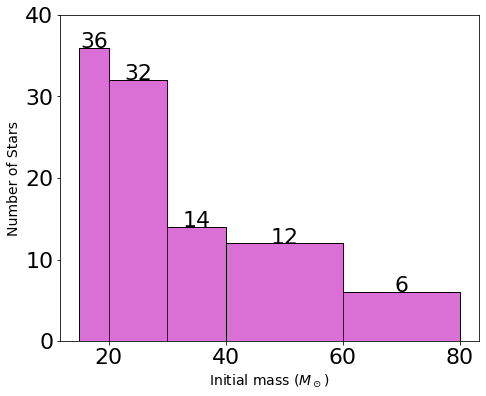

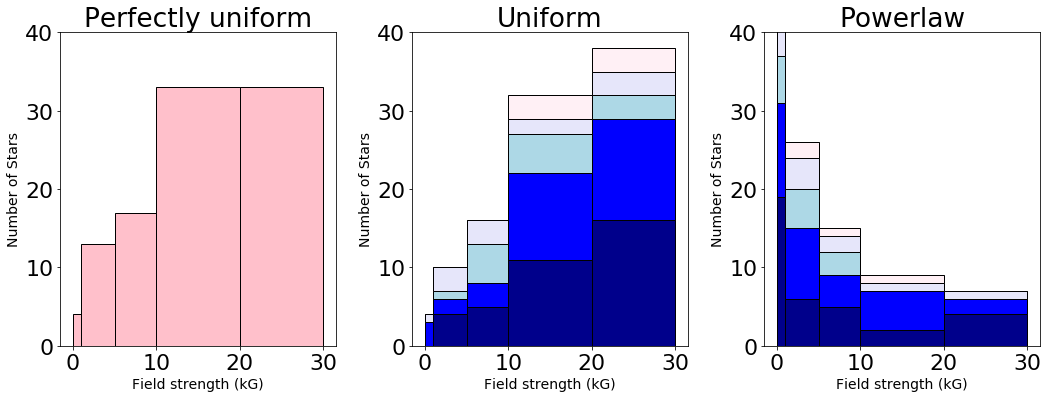

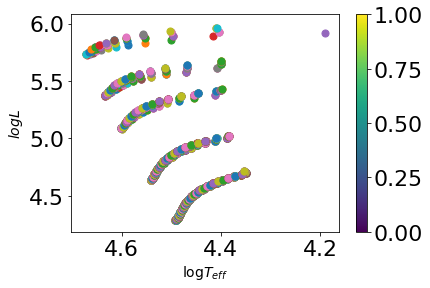

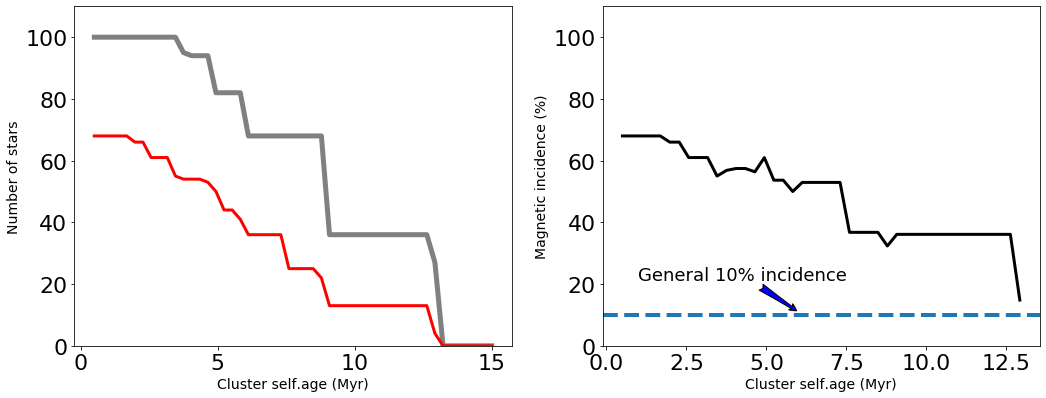

In [46]:
M_1 = np.array([ 15, 20, 30, 40, 60 ])
M_2 = np.array([ 20, 30, 40, 60, 80 ])
alpha=2.35 # Using Salpeter IMF
#epsilon_0=2860 # For 50 stars
epsilon_0=5820 # For 100 stars
file_path = r'D:\Summer2021\Magneticf\M{:0.0f}Z14B{:0.0f}.data'

b_model = np.array([0, 1, 5, 10, 20])
prueba = SingleStellarP(M_1, M_2, alpha, epsilon_0)
prueba.populhist()
prueba.initialbfunc(b_model)
prueba.singleclustersim(file_path, b_model)
prueba.displaymaginc()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: invalid value encountered in true_divide


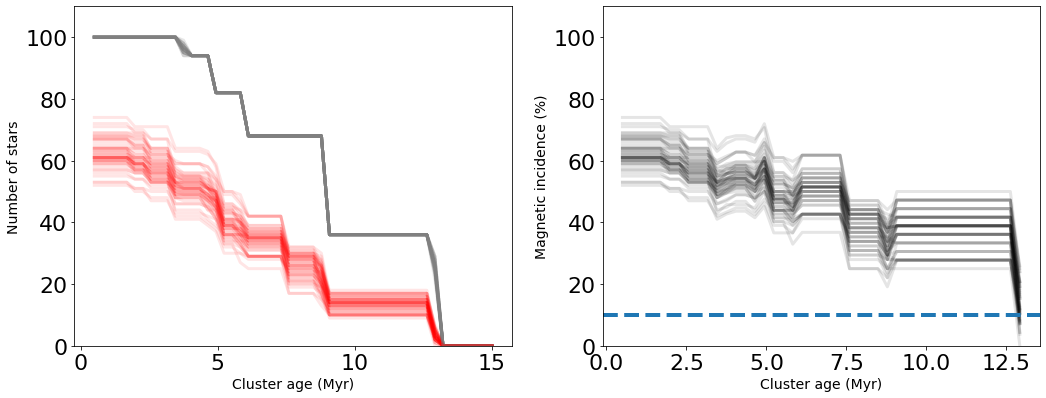

In [47]:
prueba.MCclustersim(50, file_path, b_model)
prueba.dispMCmag()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: invalid value encountered in true_divide


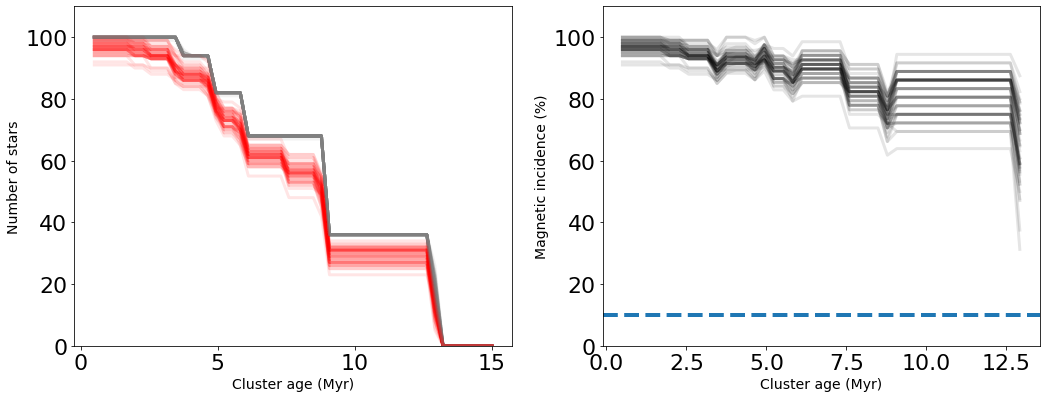

In [48]:
prueba.MCclustersim(50, file_path, b_model, powlaw = False)
prueba.dispMCmag()